In [1]:
import pandas as pd

In [5]:
df = pd.read_excel('./datafiles/JSTdatasetR4.xlsx', sheet_name='Data')

In [10]:
df = df.set_index(['country','year'])

In [33]:
df['g'] = df.groupby('country')['gdp'].pct_change()

In [ ]:
df['rg'] = df['ltrate'] - df['g']

In [78]:
df['debt_quantile'] = pd.qcut(df['debtgdp'],q=4)

<ipython-input-78-9fc563257c62>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['debt_quantile'] = pd.qcut(df['debtgdp'],q=4)


In [79]:
df = df[df.index.get_level_values(1)>2000]

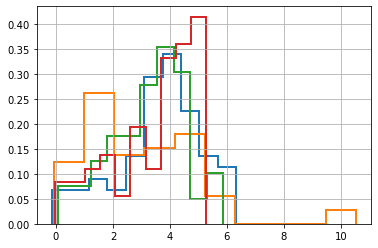

In [81]:
for q in df['debt_quantile'].unique():
    df[df.debt_quantile==q].rg.hist(density=True,histtype='step',lw=2)

In [36]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


In [43]:
mod = smf.quantreg('rg ~ debtgdp', df)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                     rg   Pseudo R-squared:             0.004796
Model:                       QuantReg   Bandwidth:                      0.7896
Method:                 Least Squares   Sparsity:                        4.784
Date:                Fri, 29 Jan 2021   No. Observations:                 2302
Time:                        11:42:19   Df Residuals:                     2300
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9197      0.084     58.322      0.000       4.754       5.085
debtgdp       -0.5985      0.127     -4.706      0.000      -0.848      -0.349


In [46]:
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['debtgdp']] + \
            res.conf_int().loc['debtgdp'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('rg ~ debtgdp', df).fit()
ols_ci = ols.conf_int().loc['debtgdp'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['debtgdp'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05   3.141529 -1.187767 -1.395474 -0.980061
1  0.15   3.600374 -0.835930 -1.016551 -0.655308
2  0.25   3.809448 -0.571230 -0.756968 -0.385493
3  0.35   4.188366 -0.468169 -0.685096 -0.251243
4  0.45   4.646570 -0.516730 -0.756054 -0.277406
5  0.55   5.123018 -0.555155 -0.822649 -0.287661
6  0.65   5.973625 -0.890629 -1.246770 -0.534487
7  0.75   7.112513 -1.400421 -1.824727 -0.976114
8  0.85   9.335713 -2.219511 -3.058559 -1.380463
9  0.95  13.696067 -3.332008 -4.319727 -2.344289
{'a': 6.034590356733953, 'b': -1.1014511316248747, 'lb': -1.409214038030568, 'ub': -0.7936882252191814}


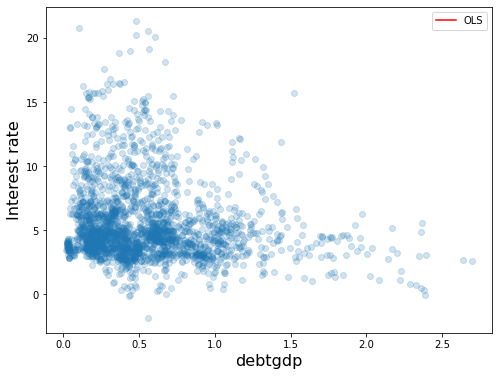

In [52]:
x = np.arange(df.debtgdp.min(), df.debtgdp.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(df.debtgdp, df.rg, alpha=.2)

legend = ax.legend()
ax.set_xlabel('debtgdp', fontsize=16)
ax.set_ylabel('Interest rate', fontsize=16);

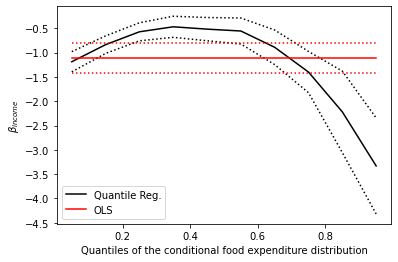

In [53]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()